# AML Challenge

## Setup

In [57]:
# Loading libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from datetime import datetime
from prettytable import PrettyTable

In [58]:
# Loading data
account = pd.read_csv('Data/account.csv', sep = ';')
client = pd.read_csv('Data/client.csv', sep = ';')
card = pd.read_csv('Data/card.csv', sep = ';')
disp = pd.read_csv('Data/disp.csv', sep = ';')
district = pd.read_csv('Data/district.csv', sep = ';')
loan = pd.read_csv('Data/loan.csv', sep = ';')
order = pd.read_csv('Data/order.csv', sep = ';')
trans = pd.read_csv('Data/trans.csv', sep = ';')

C:\Users\chant\AppData\Local\Temp/ipykernel_20280/807387847.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans = pd.read_csv('Data/trans.csv', sep = ';')


## 1. Explorative Data Analysis

### Account
Data wrangling with the csv account. Here's a brief description from the website: 

In [59]:
print(account.head())

   account_id  district_id         frequency    date
0         576           55  POPLATEK MESICNE  930101
1        3818           74  POPLATEK MESICNE  930101
2         704           55  POPLATEK MESICNE  930101
3        2378           16  POPLATEK MESICNE  930101
4        2632           24  POPLATEK MESICNE  930102


It seems that the date column is wrong, let's fix that. 

In [60]:
# Fixing the date column
account['date'] = pd.to_datetime(account['date'], format='%y%m%d')
print(account.head())

   account_id  district_id         frequency       date
0         576           55  POPLATEK MESICNE 1993-01-01
1        3818           74  POPLATEK MESICNE 1993-01-01
2         704           55  POPLATEK MESICNE 1993-01-01
3        2378           16  POPLATEK MESICNE 1993-01-01
4        2632           24  POPLATEK MESICNE 1993-01-02


In [61]:
# Translating the frequency into English
translation_frequency = {
    'POPLATEK MESICNE': 'monthly',
    'POPLATEK TYDNE': 'weekly',
    'POPLATEK PO TRANSAKCI': 'after transaction'
}

account['frequency'] = account['frequency'].map(translation_frequency)
account.head

<bound method NDFrame.head of       account_id  district_id frequency       date
0            576           55   monthly 1993-01-01
1           3818           74   monthly 1993-01-01
2            704           55   monthly 1993-01-01
3           2378           16   monthly 1993-01-01
4           2632           24   monthly 1993-01-02
...          ...          ...       ...        ...
4495         124           55   monthly 1997-12-28
4496        3958           59   monthly 1997-12-28
4497         777           30   monthly 1997-12-28
4498        1573           63   monthly 1997-12-29
4499        3276            1   monthly 1997-12-29

[4500 rows x 4 columns]>

In [62]:
print(account.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   account_id   4500 non-null   int64         
 1   district_id  4500 non-null   int64         
 2   frequency    4407 non-null   object        
 3   date         4500 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 140.8+ KB
None


In [63]:
# Checking if there are any data missing
print(account.isnull().sum())

account_id      0
district_id     0
frequency      93
date            0
dtype: int64


In [64]:
print(account['account_id'].nunique())
print(account['district_id'].nunique())

4500
77


#### Summary EDA Account

There are 4500 unique clients in 77 districs. 

### Client

In [65]:
print(client.head)

<bound method NDFrame.head of       client_id  birth_number  district_id
0             1        706213           18
1             2        450204            1
2             3        406009            1
3             4        561201            5
4             5        605703            5
...         ...           ...          ...
5364      13955        456030            1
5365      13956        430406            1
5366      13968        680413           61
5367      13971        626019           67
5368      13998        535812           74

[5369 rows x 3 columns]>


In [66]:
# Function to calculate the birthday, gender and age from birth_number
def calculate_birthday(df):
    
    genders = []
    birthdays = []
    ages = []
    
    base_date = datetime(1999, 12, 31)
    
    for birth_number in df['birth_number']:
        birth_number_str = str(birth_number)
        
        year = int("19" + birth_number_str[:2])
        month = int(birth_number_str[2:4])
        day = int(birth_number_str[4:6])
        
        if month > 12:
            gender = "female"
            month -= 50  # minus 50 for females
        else:
            gender = "male"
        
        birth_day = datetime(year, month, day)
        age = base_date.year - birth_day.year - ((base_date.month, base_date.day) < (birth_day.month, birth_day.day))
        
        genders.append(gender)
        birthdays.append(birth_day)
        ages.append(age)
    
    df['gender'] = genders
    df['birth_day'] = birthdays
    df['age'] = ages
    
    df = df.drop(columns=['birth_number'])
    
    return df

client = calculate_birthday(client)
#client.head

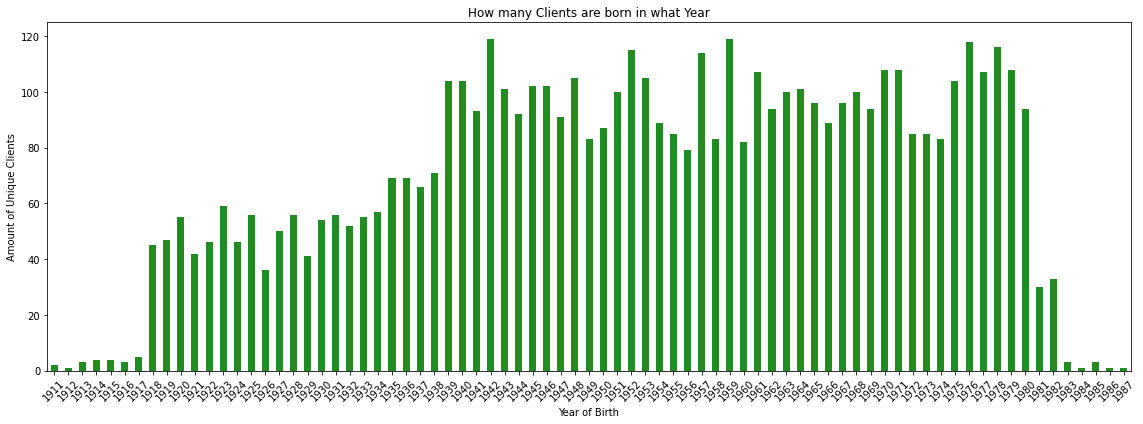

In [67]:
# Plotting the year of birth of the clients

client['birth_year'] = pd.to_datetime(client['birth_day']).dt.year
client_count_per_year = client.groupby('birth_year')['client_id'].nunique()

# Plot
plt.figure(figsize=(16, 6))
client_count_per_year.plot(kind='bar', color='forestgreen')
plt.title('How many Clients are born in what Year')
plt.xlabel('Year of Birth')
plt.ylabel('Amount of Unique Clients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Explanation of the plot*: The birthyear of the clients is from 1911 until 1987 and most of them are born between 1939 and 1980. Maybe it's an effect of the birthcontrol pill which became widly popular in Europe in the 1970s. 

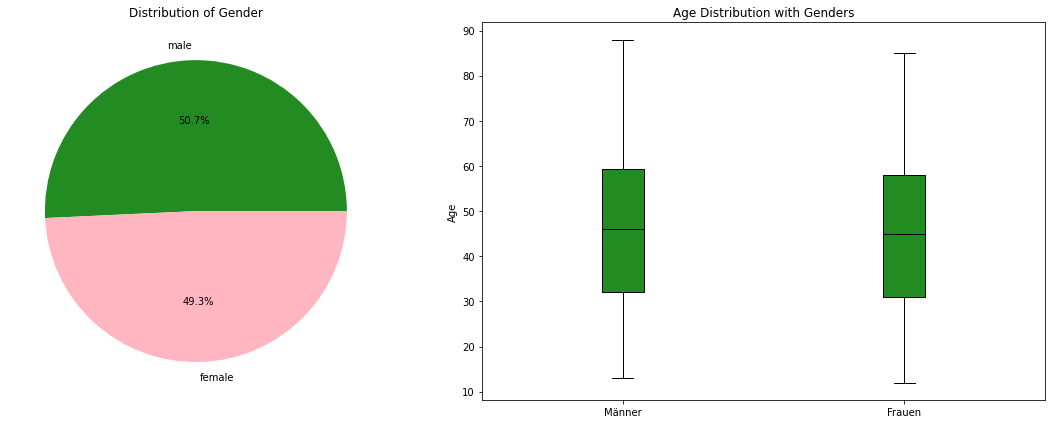

In [68]:
# Having a look at the age
colors = ['forestgreen', 'lightpink']
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
gender_counts = client['gender'].value_counts()

axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Distribution of Gender')

axes[1].boxplot([client[client['gender'] == 'male']['age'], client[client['gender'] == 'female']['age']],
                labels=['Männer', 'Frauen'], patch_artist=True,
                boxprops=dict(facecolor=colors[0]),  
                medianprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))
axes[1].set_ylabel('Age')
axes[1].set_title('Age Distribution with Genders')

# Plotting
plt.tight_layout()
plt.show()

*Explanation of the plot*: The distribution between genders and also age and gender seems to be equal. 

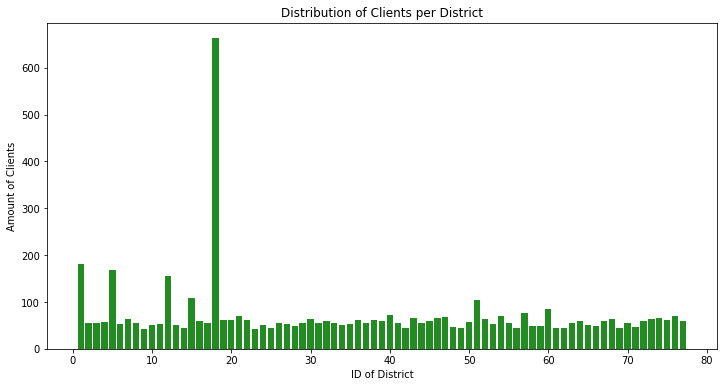

In [69]:
# How many clients are in what district
plt.figure(figsize=(12, 6))
plt.bar(client['district_id'].unique(), client['district_id'].value_counts(), color="forestgreen")
plt.xlabel('ID of District')
plt.ylabel('Amount of Clients')
plt.title('Distribution of Clients per District')
plt.show()

*Explanation of the plot*: The distribution seems normal but district 18 has many clients more than the average district. Maybe it's a big city with many habitants so there are naturally more clients. 

#### Summary EDA Client

### Card

In [70]:
# Making the table readable (issued means ausgestellt)
card['issued'] = pd.to_datetime(card['issued'], format='%y%m%d %H:%M:%S', errors='coerce')

table = PrettyTable()
table.field_names = ["card_id", "disp_id", "type", "issued"]

for index, row in card.head(10).iterrows():
    table.add_row([row['card_id'], row['disp_id'], row['type'], row['issued']])

print(table)

+---------+---------+---------+---------------------+
| card_id | disp_id |   type  |        issued       |
+---------+---------+---------+---------------------+
|   1005  |   9285  | classic | 1993-11-07 00:00:00 |
|   104   |   588   | classic | 1994-01-19 00:00:00 |
|   747   |   4915  | classic | 1994-02-05 00:00:00 |
|    70   |   439   | classic | 1994-02-08 00:00:00 |
|   577   |   3687  | classic | 1994-02-15 00:00:00 |
|   377   |   2429  | classic | 1994-03-03 00:00:00 |
|   721   |   4680  |  junior | 1994-04-05 00:00:00 |
|   437   |   2762  | classic | 1994-06-01 00:00:00 |
|   188   |   1146  | classic | 1994-06-19 00:00:00 |
|    13   |    87   | classic | 1994-06-29 00:00:00 |
+---------+---------+---------+---------------------+


In [71]:
# How many card types are there?
print(card['type'].value_counts())

classic    659
junior     145
gold        88
Name: type, dtype: int64


#### Summary EDA Card
There are three card types: classic (659), junior (145) and gold (88). 

### Disp

In [72]:
disp.head

<bound method NDFrame.head of       disp_id  client_id  account_id       type
0           1          1           1      OWNER
1           2          2           2      OWNER
2           3          3           2  DISPONENT
3           4          4           3      OWNER
4           5          5           3  DISPONENT
...       ...        ...         ...        ...
5364    13647      13955       11349      OWNER
5365    13648      13956       11349  DISPONENT
5366    13660      13968       11359      OWNER
5367    13663      13971       11362      OWNER
5368    13690      13998       11382      OWNER

[5369 rows x 4 columns]>

In [73]:
# Checking if one account can have more than one client

multiple_clients_per_account = disp.groupby(['account_id'])['client_id'].nunique().reset_index(name='unique_clients')
multiple_clients_per_account = multiple_clients_per_account[multiple_clients_per_account['unique_clients'] > 1]
print(multiple_clients_per_account)

# Here is a list with which accounts have an owner and a disponent

      account_id  unique_clients
1              2               2
2              3               2
7              8               2
11            12               2
12            13               2
...          ...             ...
4464       10940               2
4466       10954               2
4479       11111               2
4484       11186               2
4496       11349               2

[869 rows x 2 columns]


In [74]:
# Checking if one client has more than one account
multiple_accounts_per_client = disp.groupby('client_id')['account_id'].nunique().reset_index(name='unique_accounts')
multiple_accounts_per_client = multiple_accounts_per_client[multiple_accounts_per_client['unique_accounts'] > 1]
print(multiple_accounts_per_client)

Empty DataFrame
Columns: [client_id, unique_accounts]
Index: []


#### Summary EDA Disp
Some accounts have two unique clients (with unique client IDs) so some of them have an owner and a disponent. But no client has more than one account. 

### District

In [75]:
district.head

<bound method NDFrame.head of     A1               A2               A3       A4  A5  A6  A7  A8  A9    A10  \
0    1      Hl.m. Praha           Prague  1204953   0   0   0   1   1  100.0   
1    2          Benesov  central Bohemia    88884  80  26   6   2   5   46.7   
2    3           Beroun  central Bohemia    75232  55  26   4   1   5   41.7   
3    4           Kladno  central Bohemia   149893  63  29   6   2   6   67.4   
4    5            Kolin  central Bohemia    95616  65  30   4   1   6   51.4   
..  ..              ...              ...      ...  ..  ..  ..  ..  ..    ...   
72  73            Opava    north Moravia   182027  17  49  12   2   7   56.4   
73  74  Ostrava - mesto    north Moravia   323870   0   0   0   1   1  100.0   
74  75           Prerov    north Moravia   138032  67  30   4   2   5   64.6   
75  76          Sumperk    north Moravia   127369  31  32  13   2   7   51.2   
76  77           Vsetin    north Moravia   148545   8  35  12   3   4   53.5   

      A11

In [76]:
# Renaming the columns
new_column_names = ['district_id', 'district_name', 'region', 'inhabitants', 'villages_less_499', 'villages_500_to_1999', 'villages_2000_to_9999', 'villages_with_more_10000', 'number_of_cities', 'ratio_urban_inhabitants', 
                    'average_salary','unemployment_rate_95', 'unemployment_rate_96', 'entrepreneurs_per_1000_inhabitants', 'committed_crimes_95', 'committed_crimes_96']

# Annahme: df ist dein DataFrame
district.columns = new_column_names
district.iloc

#### Summary EDA District
This dataframe contains information about the districts. Czechia only has four regions similar to the four regions of Switzerland (Romandie, Deutschschweiz, etc.). 

### Loan

In [77]:
loan.head

<bound method NDFrame.head of      loan_id  account_id    date  amount  duration  payments status
0       5314        1787  930705   96396        12    8033.0      B
1       5316        1801  930711  165960        36    4610.0      A
2       6863        9188  930728  127080        60    2118.0      A
3       5325        1843  930803  105804        36    2939.0      A
4       7240       11013  930906  274740        60    4579.0      A
..       ...         ...     ...     ...       ...       ...    ...
677     4989         105  981205  352704        48    7348.0      C
678     5221        1284  981205   52512        12    4376.0      C
679     6402        6922  981206  139488        24    5812.0      C
680     5346        1928  981206   55632        24    2318.0      C
681     6748        8645  981208  240900        60    4015.0      C

[682 rows x 7 columns]>

In [78]:
# Changing payment status into words
status_mapping = {
    'A': 'contract finished, no problems',
    'B': 'contract finished, loan not payed',
    'C': 'running contract, OK so far',
    'D': 'running contract, client in debt'
}

# Anwenden des Mappings auf die Spalte 'status'
loan['status'] = loan['status'].map(status_mapping)
loan.head

<bound method NDFrame.head of      loan_id  account_id    date  amount  duration  payments  \
0       5314        1787  930705   96396        12    8033.0   
1       5316        1801  930711  165960        36    4610.0   
2       6863        9188  930728  127080        60    2118.0   
3       5325        1843  930803  105804        36    2939.0   
4       7240       11013  930906  274740        60    4579.0   
..       ...         ...     ...     ...       ...       ...   
677     4989         105  981205  352704        48    7348.0   
678     5221        1284  981205   52512        12    4376.0   
679     6402        6922  981206  139488        24    5812.0   
680     5346        1928  981206   55632        24    2318.0   
681     6748        8645  981208  240900        60    4015.0   

                                status  
0    contract finished, loan not payed  
1       contract finished, no problems  
2       contract finished, no problems  
3       contract finished, no problem

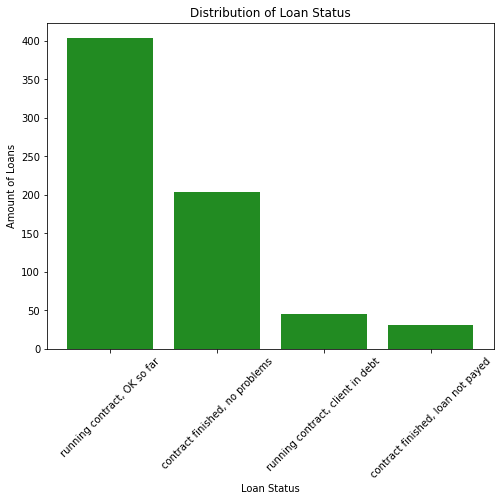

In [80]:
# Checking which status occurs the most
status_counts = loan['status'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
plt.bar(status_counts.index, status_counts.values, color="forestgreen")
plt.xlabel('Loan Status')
plt.ylabel('Amount of Loans')
plt.title('Distribution of Loan Status')
plt.xticks(rotation=45)
plt.show()

In [82]:
# Changing the column date into datetime format
loan['date'] = pd.to_datetime(loan['date'], format='%y%m%d')
loan

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,"contract finished, loan not payed"
1,5316,1801,1993-07-11,165960,36,4610.0,"contract finished, no problems"
2,6863,9188,1993-07-28,127080,60,2118.0,"contract finished, no problems"
3,5325,1843,1993-08-03,105804,36,2939.0,"contract finished, no problems"
4,7240,11013,1993-09-06,274740,60,4579.0,"contract finished, no problems"
...,...,...,...,...,...,...,...
677,4989,105,1998-12-05,352704,48,7348.0,"running contract, OK so far"
678,5221,1284,1998-12-05,52512,12,4376.0,"running contract, OK so far"
679,6402,6922,1998-12-06,139488,24,5812.0,"running contract, OK so far"
680,5346,1928,1998-12-06,55632,24,2318.0,"running contract, OK so far"


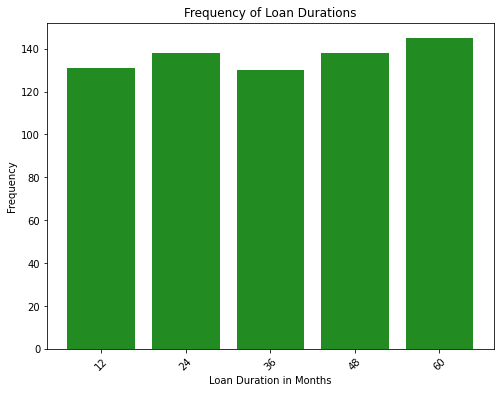

In [88]:
# How popular is which duration of the loan?
duration_counts_sorted = loan['duration'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 6))
plt.bar(duration_counts_sorted.index.astype(str), duration_counts_sorted.values, color="forestgreen")
plt.xlabel('Loan Duration in Months')
plt.ylabel('Frequency')
plt.title('Frequency of Loan Durations')
plt.xticks(rotation=45)
plt.show()

In [85]:
loan['duration'].describe()

count    682.000000
mean      36.492669
std       17.075219
min       12.000000
25%       24.000000
50%       36.000000
75%       48.000000
max       60.000000
Name: duration, dtype: float64

In [89]:
# Can one account have more than one loan?
account_loan_counts = loan['account_id'].value_counts()
print(account_loan_counts[account_loan_counts > 1])

Series([], Name: account_id, dtype: int64)


#### Summary EDA Loan
Every loan has an unique ID which is connected so the account_id. The loans are also categorised and the duration is in months. The minimal duration is 12 months and the maximum duration is 60 months. There is no account with more than one loan. 

### Order

In [91]:
order

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,SIPO
1,29402,2,ST,89597016,3372.7,UVER
2,29403,2,QR,13943797,7266.0,SIPO
3,29404,3,WX,83084338,1135.0,SIPO
4,29405,3,CD,24485939,327.0,
...,...,...,...,...,...,...
6466,46334,11362,YZ,70641225,4780.0,SIPO
6467,46335,11362,MN,78507822,56.0,
6468,46336,11362,ST,40799850,330.0,POJISTNE
6469,46337,11362,KL,20009470,129.0,


### Trans

## 2. Combining information on customers and banking services
We combine the data from the six CSVs with eachother to see how they are being used. In the dataset disp.csv we have disp_id and client_id and account_id so we can combine the client to an account and also see if he's an owner or disponent.  

## 3. Data Cleaning
Here we "clean" the data which means we decide, what data we will use for the models. 